# Working with MEG dataset
MEG dataset from THINGS initiative: https://openneuro.org/datasets/ds004212/versions/2.0.1
### Training data partition
The data is .fif file which needs to be converted into a rather easy to use .npy array.
We will use mne library for this: https://mne.tools/dev/index.html 


We collected extensively sampled object representations using magnetoencephalography (MEG). To this end, we drew on the THINGS database (Hebart et al., 2019), a richly-annotated database of 1,854 object concepts representative of the American English language which contains 26,107 manually-curated naturalistic object images.

ERP = event-related potential; signal with respect to some event
VEP = ERP for visual stimuli



27084 events, 281 time points, 271 channels

In [2]:
import numpy as np
import mne, os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import matplotlib.image as mpimg
import nimfa

In [3]:
channel_picks               = ['O','T','P']
file_path = 'preprocessed/preprocessed_P1-epo.fif'
def load_epochs(file_path,all_epochs = []):
    epochs = mne.read_epochs(file_path, preload=False)
    return epochs
epochs = load_epochs(file_path)

Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/asuryawanshi/Documents/THINGS/MEG/preprocessed/preprocessed_P1-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied
0 projection items activated


In [4]:
epochs.metadata

trial_type  image_nr  category_nr  exemplar_nr  test_image_nr  \
0            exp     21118         1760           10            NaN   
1            exp      6922          577           10            NaN   
2            exp      7522          627           10            NaN   
3            exp      2950          246           10            NaN   
4            exp     18682         1557           10            NaN   
...          ...       ...          ...          ...            ...   
27043        exp       303           26            3            NaN   
27044        exp      1671          140            3            NaN   
27045        exp     16083         1341            3            NaN   
27046        exp      4731          395            3            NaN   
27047        exp      5103          426            3            NaN   

       things_category_nr  things_image_nr  things_exemplar_nr  \
0                  1760.0          24812.0                10.0   
1                   577.0           8355.0                10.0   
2                   627.0           9054.0                10.0   
3                   246.0           3648.0                10.0   
4                  1557.0          21998.0                10.0   
...                   ...              ...                 ...   
27043                26.0            358.0                 3.0   
27044               140.0           2131.0                 3.0   
27045              1341.0          19070.0                 3.0   
27046               395.0           5680.0                 3.0   
27047               426.0           6138.0                 3.0   

                                   image_path   onset    image_on   image_off  \
0                images_meg/vest/vest_10s.jpg    3.00    3.005025    3.505181   
1      images_meg/fencepost/fencepost_10s.jpg    4.65    4.655683    5.155901   
2            images_meg/fondue/fondue_10s.jpg    6.00    6.206278    6.706482   
3              images_meg/camel/camel_10s.jpg    7.50    7.556825    8.056974   
4        images_meg/stingray/stingray_10s.jpg    9.00    9.074120    9.574357   
...                                       ...     ...         ...         ...   
27043    images_meg/anteater/anteater_03s.jpg  333.25  333.331516  333.831749   
27044          images_meg/blimp/blimp_03n.jpg  334.65  334.832104  335.332262   
27045              images_meg/rug/rug_03s.jpg  336.00  336.215922  336.716176   
27046    images_meg/computer/computer_03n.jpg  337.60  337.599834  338.100026   
27047    images_meg/coverall/coverall_03s.jpg  339.20  339.200461  339.700626   

       responded  key_id  key_time  RT  session_nr  run_nr  
0              0     NaN       NaN NaN           1       1  
1              0     NaN       NaN NaN           1       1  
2              0     NaN       NaN NaN           1       1  
3              0     NaN       NaN NaN           1       1  
4              0     NaN       NaN NaN           1       1  
...          ...     ...       ...  ..         ...     ...  
27043          0     NaN       NaN NaN          12      10  
27044          0     NaN       NaN NaN          12      10  
27045          0     NaN       NaN NaN          12      10  
27046          0     NaN       NaN NaN          12      10  
27047          0     NaN       NaN NaN          12      10  

[27048 rows x 18 columns]

In [5]:
name = channel_picks[0]
print(name, channel_picks)
# ctf_layout = mne.find_layout(epochs.info)
picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
ep1 = epochs[epochs.metadata['trial_type']=='exp']  
ep1.load_data() 
ep1.pick_channels(ch_names=picks_epochs); # supress output


O ['O', 'T', 'P']
Loading data for 22248 events and 281 original time points ...


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [6]:
NOS_CONCEPTS = 1854
NOS_IMAGE_PER_CONCEPT = 12
NOS_CHANNELS_OPT = 39
NOS_TIME_POINTS = 281
time_points = epochs.times 

In [7]:
# Load concept epochs if they already exist
if os.path.exists('concept_epochs.npy'):
    concept_epochs = np.load('concept_epochs.npy')
else:
    # Initialize the concept_epochs array with zeros
    concept_epochs = np.zeros((NOS_IMAGE_PER_CONCEPT, NOS_CONCEPTS, NOS_TIME_POINTS, NOS_CHANNELS_OPT))
    
    # Extract all data matching the condition in one go
    indices = ep1.metadata['category_nr'].values - 1  # Adjust index (assuming category_nr starts at 1)
    concept_epochs[:, indices, :, :] = ep1._data.transpose(0, 2, 1)
    
    # Save the array
    np.save('concept_epochs.npy', concept_epochs)

In [8]:
concept_epochs.shape

(12, 1854, 281, 39)

In [9]:
filtered_indices = (epochs._raw_times > 0.07) & (epochs._raw_times < 0.370)
concept_epochs = concept_epochs[:, :, filtered_indices, :]

In [10]:
average_concept_epochs = concept_epochs.mean(axis = 0)
average_concept_epochs.shape

(1854, 59, 39)

In [11]:
z_scored_epochs = np.zeros_like(average_concept_epochs)
for channel in range(NOS_CHANNELS_OPT):
    mean = average_concept_epochs[:,channel,:].mean()
    stdev = average_concept_epochs[:,channel,:].std()
    z_scored_epochs[:,channel,:] = (average_concept_epochs[:,channel,:] - mean) / stdev
z_scored_epochs+= abs(z_scored_epochs.min()) # make all values positive  

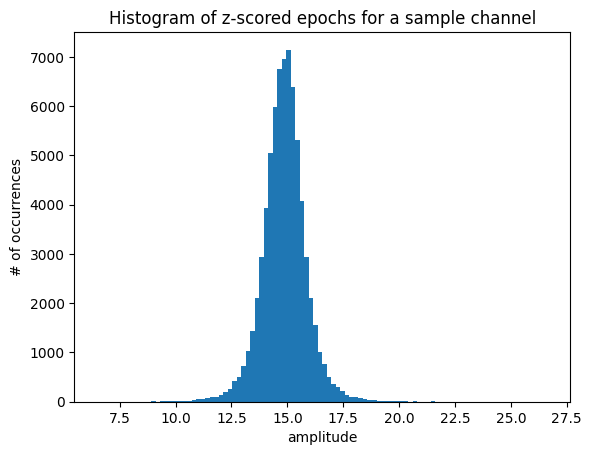

(1854, 59, 39)

In [12]:

plt.hist(z_scored_epochs[:,2,:].flatten(), bins=100)
plt.title('Histogram of z-scored epochs for a sample channel')
plt.xlabel('amplitude')
plt.ylabel('# of occurrences') 
plt.show()
z_scored_epochs.shape 

In [13]:
X = z_scored_epochs.reshape(NOS_CONCEPTS, average_concept_epochs.shape[1]*NOS_CHANNELS_OPT)
X.shape

(1854, 2301)

In [14]:
def fit_bnmf(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=500, min_residuals=1e-4, alpha=np.zeros((V.shape[0], k)),
                        beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=100, stride=1,
                        n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = bnmf_fit.basis()
    H = bnmf_fit.coef()
    return np.array(W), np.array(H)

def compute_evar_all(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    V_hat = np.dot(W, H)
    rss = np.sum(np.asarray(V_hat - V)**2)
    evar_all = 1. - rss / (V*V).sum()
    return evar_all

def compute_evar_indiv(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int):
    V_hat_d = np.outer(W[:, d], H[d, :])
    rss = np.sum(np.asarray(V_hat_d - V)**2)
    evar_indiv = 1. - rss / (V*V).sum()
    return evar_indiv

def compute_evar_unique(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int, evar_all: float):
    V_hat_wo_d = np.dot(W[:, np.arange(W.shape[1]) != d], H[np.arange(H.shape[0]) != d, :])
    rss = np.sum(np.asarray(V_hat_wo_d - V)**2)
    evar_rest = 1. - rss / (V*V).sum()
    evar_unique = evar_all - evar_rest
    return evar_unique

$$X = W \times H$$
1854 is the number of data points and time*channels is the dimensionality of each data point.
$W$ is the matrix of basis vectors and $H$ is the coefficient of activity of this basis vectors. 

In [15]:
import scipy.stats as st

def compute_log_likelihood(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute log-likelihood."""
    V_hat = np.dot(W, H)
    err_std_dev = np.sqrt(np.var(V - V_hat))
    log_likelihood = st.norm.logpdf(V, loc=V_hat, scale=err_std_dev).sum()
    return log_likelihood

def compute_aic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute AIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    aic = 2 * n_free_params - 2 * log_likelihood
    return aic, n_free_params

def compute_bic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute BIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    I, J = V.shape
    n_samples = I * J
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    bic = np.log(n_samples) * n_free_params - 2 * log_likelihood
    return bic

In [41]:
nmf_components = 250 # 3 mins for 30 components 
BAYESIAN = 1

# Directory to save/load the matrices
directory = 'NMF_matrices'  

# Check if W, H exists in folder and load them
if os.path.isfile(f'{directory}/W_{nmf_components}.npy') and os.path.isfile(f'{directory}/H_{nmf_components}.npy'):
    W = np.load(f'{directory}/W_{nmf_components}.npy')
    H = np.load(f'{directory}/H_{nmf_components}.npy')
else:
    if BAYESIAN:
        W, H = fit_bnmf(X, nmf_components)
        X_pred = np.dot(W, H)
    else:
        model = NMF(n_components=nmf_components)
        W = model.fit_transform(X)
        H = model.components_
        X_pred = np.dot(W, H)
    np.save(f'{directory}/W_{nmf_components}.npy', W)
    np.save(f'{directory}/H_{nmf_components}.npy', H)

In [51]:
print(compute_evar_all(X, W, H))

0.9999415267060455


In [49]:
array_dim = [2, 5, 10, 15, 20, 50, 100, 200, 250, 300]
W_dict = {} 
H_dict = {} 

for dim in array_dim:
    if os.path.isfile(f'{directory}/W_{dim}.npy') and os.path.isfile(f'{directory}/H_{dim}.npy'):
        W_dict[dim] = np.load(f'{directory}/W_{dim}.npy')
        H_dict[dim] = np.load(f'{directory}/H_{dim}.npy')
# # load matrices from directory
# W_2 = np.load(f'{directory}/W_2.npy')
# H_2 = np.load(f'{directory}/H_2.npy')
# W_5 = np.load(f'{directory}/W_5.npy')   
# H_5 = np.load(f'{directory}/H_5.npy')
# W_10 = np.load(f'{directory}/W_10.npy')
# H_10 = np.load(f'{directory}/H_10.npy')
# W_15 = np.load(f'{directory}/W_15.npy')
# H_15 = np.load(f'{directory}/H_15.npy')
# W_20 = np.load(f'{directory}/W_20.npy')
# H_20 = np.load(f'{directory}/H_20.npy')
# W_50 = np.load(f'{directory}/W_50.npy')
# H_50 = np.load(f'{directory}/H_50.npy')     
# W_100 = np.load(f'{directory}/W_100.npy')
# H_100 = np.load(f'{directory}/H_100.npy')   
# W_200 = np.load(f'{directory}/W_200.npy')                       
# H_200 = np.load(f'{directory}/H_200.npy')
# W_250 = np.load(f'{directory}/W_250.npy')
# H_250 = np.load(f'{directory}/H_250.npy')
# W_300 = np.load(f'{directory}/W_300.npy')
# H_300 = np.load(f'{directory}/H_300.npy')

BIC_array = np.zeros(len(array_dim))
AIC_array = np.zeros(len(array_dim))
explained_variance = np.zeros(len(array_dim))   
for i, dim in enumerate(array_dim):
    W = W_dict[dim]
    H = H_dict[dim]
    BIC_array[i] = compute_bic(X, W, H)
    AIC_array[i] = compute_aic(X, W, H)[0]
    explained_variance[i] = compute_evar_all(X, W, H)


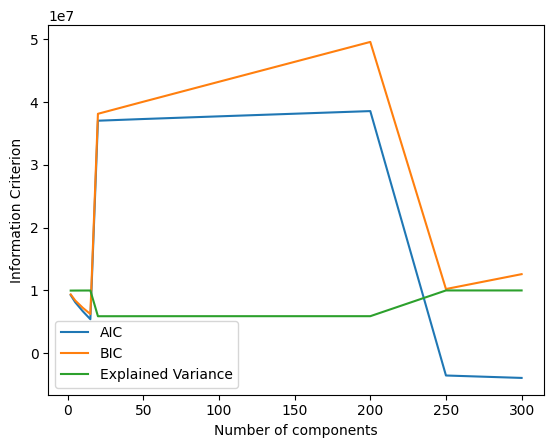

In [ ]:
# plot AIC and BIC
plt.plot(array_dim, AIC_array, label='AIC')     
plt.plot(array_dim, BIC_array, label='BIC')    
plt.plot(array_dim, explained_variance, label='Explained Variance')         
plt.xlabel('Number of components')          
plt.ylabel('Information Criterion')                 
plt.legend()        
plt.show()  


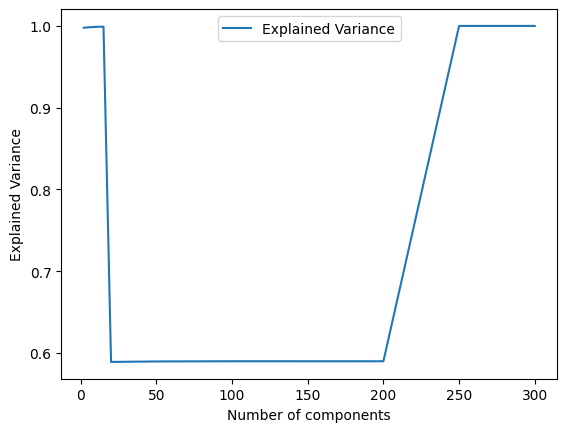

In [55]:
plt.plot(array_dim, explained_variance, label='Explained Variance')   
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')            
plt.legend()    
plt.show()  

In [ ]:
array_dim = [2, 5, 10, 15, 20, 50, 100, 200, 250, 300]

# compute BIC 
print(f"BIC of 2 is {compute_bic(X, W_2, H_2)}")    
print(f"BIC of 5 is {compute_bic(X, W_5, H_5)}")
print(f"BIC of 10 is {compute_bic(X, W_10, H_10)}")  
print(f"BIC of 15 is {compute_bic(X, W_15, H_15)}")               
print(f"BIC of 20 is {compute_bic(X, W_20, H_20)}")             
print(f"BIC of 50 is {compute_bic(X, W_50, H_50)}")
print(f"BIC of 100 is {compute_bic(X, W_100, H_100)}")
print(f"BIC of 200 is {compute_bic(X, W_200, H_200)}")
print(f"BIC of 250 is {compute_bic(X, W_250, H_250)}")
print(f"BIC of 300 is {compute_bic(X, W_300, H_300)}")


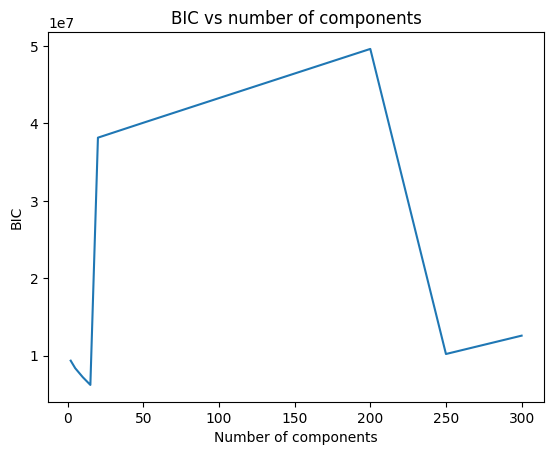

In [43]:
#plot bic's 
bic = [compute_bic(X, W_2, H_2), compute_bic(X, W_5, H_5), compute_bic(X, W_10, H_10), compute_bic(X, W_15, H_15), compute_bic(X, W_20, H_20), compute_bic(X, W_50, H_50), compute_bic(X, W_100, H_100), compute_bic(X, W_200, H_200), compute_bic(X, W_250, H_250), compute_bic(X, W_300, H_300)]
plt.plot([2, 5, 10, 15, 20, 50, 100, 200,250, 300], bic)
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC vs number of components')
plt.show()

In [26]:
W.shape, H.shape

((1854, 10), (10, 2301))

In [27]:
# indices which has max value on W
sorted_indices = np.argsort(W[:,0])
sorted_indices.shape

(1854,)

In [28]:
nmf_components_vs_category = np.zeros((nmf_components, 10))
for i in range(nmf_components):
    sorted_indices = np.argsort(W[:,i])
    print(f'Categories which are best on component {i} are: {sorted_indices[-10:]}')
    nmf_components_vs_category[i,:] = sorted_indices[-10:]


Categories which are best on component 0 are: [  39 1137 1771 1692  188 1430  801  482 1530 1543]
Categories which are best on component 1 are: [ 246 1135 1409  175  470  576 1751 1467 1674  143]
Categories which are best on component 2 are: [1204  932 1336 1267  655 1750  477  593  656  325]
Categories which are best on component 3 are: [1818  641  846 1566 1014 1657 1114 1157  955 1234]
Categories which are best on component 4 are: [ 905 1771 1709  640 1676 1677 1227 1530 1044  482]
Categories which are best on component 5 are: [1271 1790  187 1347  652 1053  135  801 1646  745]
Categories which are best on component 6 are: [  44  406  169  735  848  270 1241 1425  325  482]
Categories which are best on component 7 are: [ 325  955  145 1186 1591  600 1751  624  765 1749]
Categories which are best on component 8 are: [1500   48  360  265 1045  690 1143 1751 1499  325]
Categories which are best on component 9 are: [1813  738   18  590   20  924  620  480 1317  392]


In [29]:
for component in range(nmf_components):
    print(f"Component {component} is best loaded by the following image categories:")
    for i in range(10):
        category_nr = nmf_components_vs_category[component, i] 
        # Get the image paths for the given category_nr
        image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
        
        if not image_paths.empty:
            # Print the folder name only for the first occurrence
            first_image_path = image_paths.iloc[0]
            folder_name = os.path.dirname(first_image_path)
            print(f"Category {category_nr} - {folder_name}")
        else:
            print(f"Category {category_nr} - No image paths found ")
            break

    print('\n')

Component 0 is best loaded by the following image categories:
Category 39.0 - images_meg/artichoke
Category 1137.0 - images_meg/pedometer
Category 1771.0 - images_meg/waffle_iron
Category 1692.0 - images_meg/towel
Category 188.0 - images_meg/bracelet2
Category 1430.0 - images_meg/shorts
Category 801.0 - images_meg/hot_chocolate
Category 482.0 - images_meg/detonator
Category 1530.0 - images_meg/squirt_gun
Category 1543.0 - images_meg/statue


Component 1 is best loaded by the following image categories:
Category 246.0 - images_meg/camera_lens
Category 1135.0 - images_meg/pecan


Category 1409.0 - images_meg/shark
Category 175.0 - images_meg/bow2
Category 470.0 - images_meg/daisy
Category 576.0 - images_meg/fencepost
Category 1751.0 - images_meg/valve
Category 1467.0 - images_meg/slingshot
Category 1674.0 - images_meg/tongs
Category 143.0 - images_meg/block


Component 2 is best loaded by the following image categories:
Category 1204.0 - images_meg/plunger
Category 932.0 - images_meg/lingerie
Category 1336.0 - images_meg/router
Category 1267.0 - images_meg/racehorse
Category 655.0 - images_meg/garbage
Category 1750.0 - images_meg/vacuum
Category 477.0 - images_meg/defibrillator
Category 593.0 - images_meg/fire_pit
Category 656.0 - images_meg/garbage_truck
Category 325.0 - images_meg/chickpea


Component 3 is best loaded by the following image categories:
Category 1818.0 - images_meg/window
Category 641.0 - images_meg/french_fries
Category 846.0 - images_meg/jersey
Category 1566.0 - images_meg/strainer
Category 1014.0 - images_meg/mole
Category 1657.0 - images_m

Component 0 is best loaded by the following image categories:


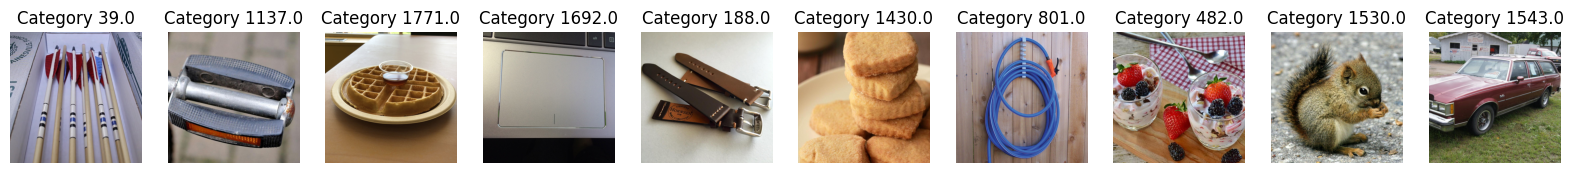

Component 1 is best loaded by the following image categories:


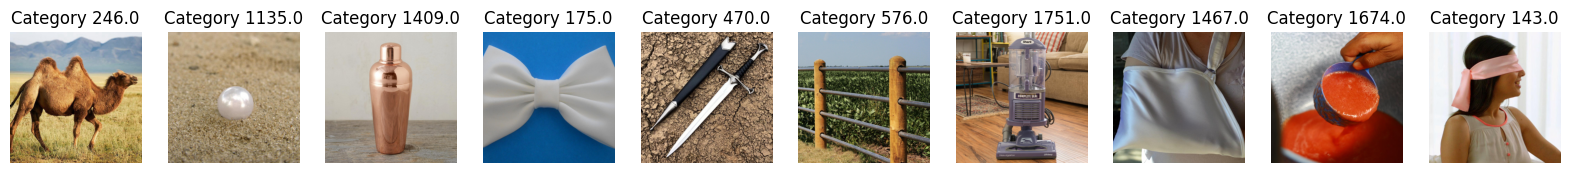

Component 2 is best loaded by the following image categories:


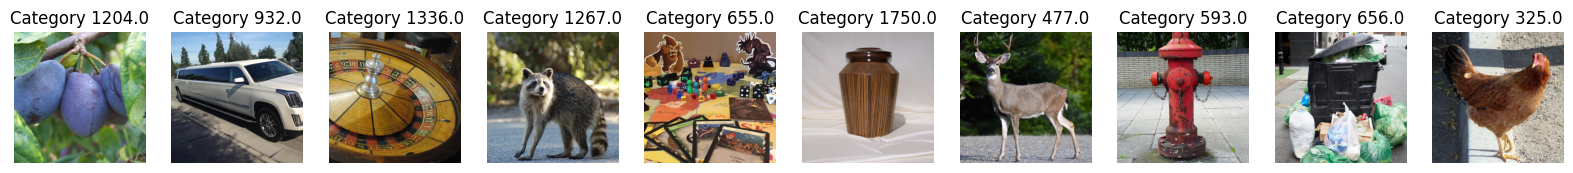

Component 3 is best loaded by the following image categories:


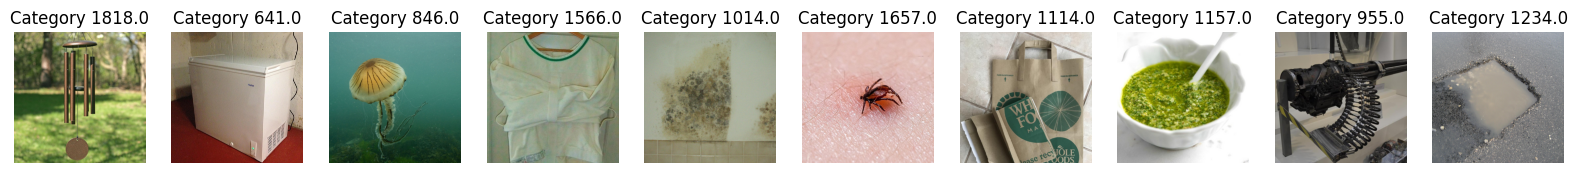

Component 4 is best loaded by the following image categories:


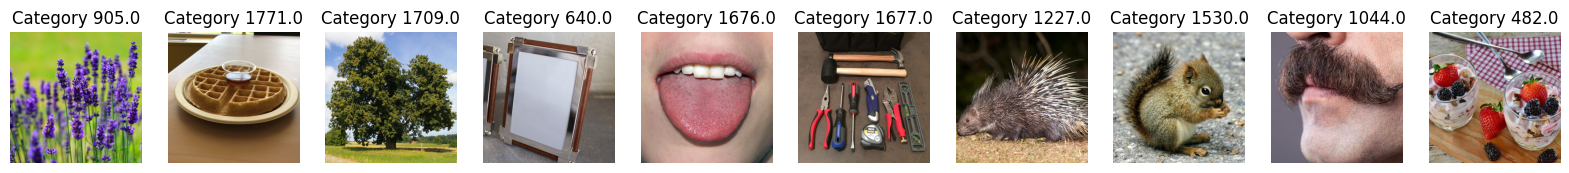

Component 5 is best loaded by the following image categories:


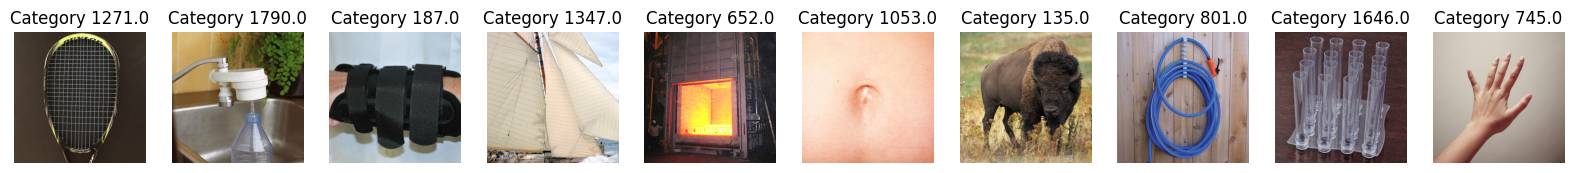

Component 6 is best loaded by the following image categories:


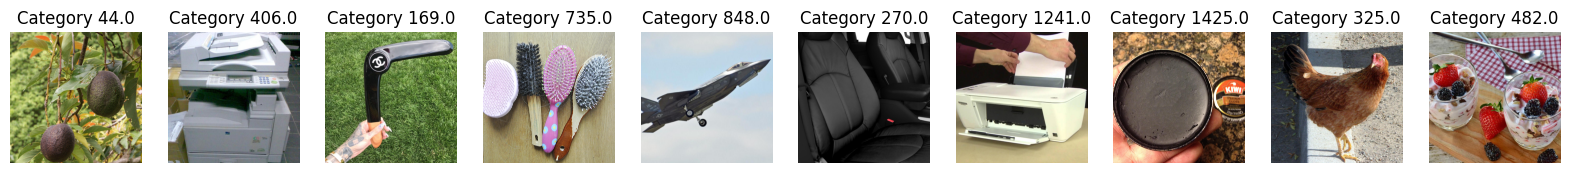

Component 7 is best loaded by the following image categories:


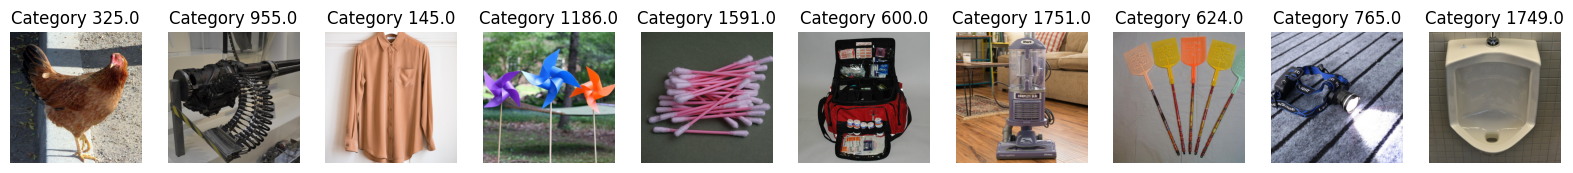

Component 8 is best loaded by the following image categories:


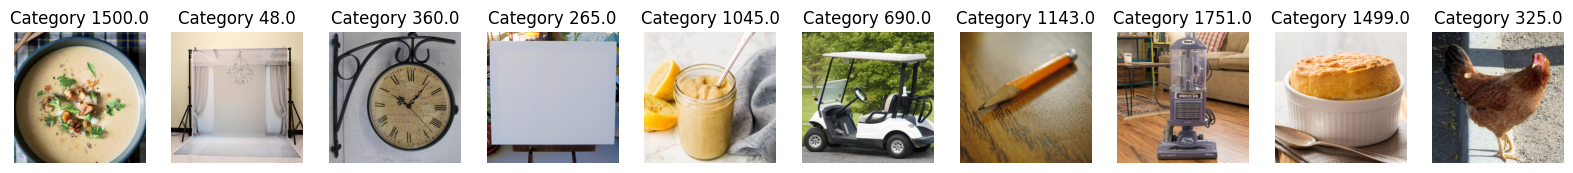

Component 9 is best loaded by the following image categories:


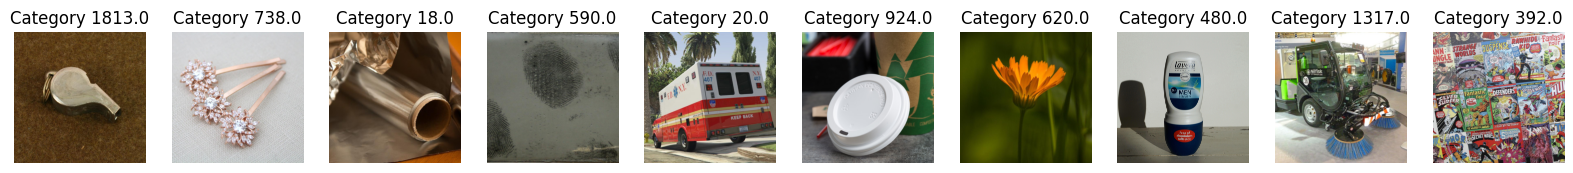

In [30]:
# plot images for the top 5 categories for each component   
for component in range(nmf_components):
    if component > 20:
        break
    print(f"Component {component} is best loaded by the following image categories:")
    fig, axs = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        category_nr = nmf_components_vs_category[component, i] 
        # Get the image paths for the given category_nr
        image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
        image_path = image_paths.iloc[0]
        img = mpimg.imread(image_path)
        axs[i].imshow(img)
        axs[i].set_title(f"Category {category_nr}")
        axs[i].axis('off')
    plt.show()
    